In [1]:
# from fastapi import FastAPI, File, UploadFile
# from fastapi.encoders import jsonable_encoder
# from fastapi.responses import JSONResponse
# from fastapi.middleware.cors import CORSMiddleware
# from starlette.middleware.cors import CORSMiddleware
import json
# from yahoofinancials import YahooFinancials as YF
import time
import datetime
import pandas as pd
# from pandas_datareader import data
from pandas_datareader import data as pdr

import yfinance as yf
yf.pdr_override() # <== that's all it takes :-)

from typing import List, Optional
import os
import pickle 
from tqdm import tqdm
import scipy.stats as sp
from utils import *
# from pydantic import BaseModelttt
from backtester import *
from backtest import *
import matplotlib.pyplot as plt
# import quandl

%matplotlib inline

In [2]:
# gets stock ticket data for current day going back days_back
def getStocksData(tickers, days_back=10, save_new=False, path=r"C:\Users\moyer\OneDrive\development\fin-dashboard\app\stocks.pkl"):
    def convert_time(epoch):
        return time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(epoch))

    epoch_time = int(time.time())
    day_epoch = 60*60*24
    # tickers = df['Symbol'][:10]
    stocks = {}
    if (save_new):
        for tick in tqdm(tickers):
            try:

                # download dataframe
                # data = pdr.get_data_yahoo("SPY", start="2017-01-01", end="2017-04-30")
                # data
                # stock_data =  pdr.get_data_yahoo(tick, start="2017-01-01", end="2022-02-20")
                stock_data =  pdr.get_data_yahoo(tick, period="3mo")
                stocks[tick] = stock_data
                with open(path, 'wb') as handle:
                    pickle.dump(stocks, handle,
                                protocol=pickle.HIGHEST_PROTOCOL)
            except:
                print("Skipping stock for {}, bad data :<".format(tick))
    else:
        with open(path, 'rb') as handle:
            stocks = pickle.load(handle)
    return stocks

In [3]:
tickers = ['AAPL','T', 'MSFT']
stocks = getStocksData(tickers, 100, save_new=True)
stocks[tickers[0]].head()

  0%|          | 0/3 [00:00<?, ?it/s]

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- AAPL: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- T: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

100%|██████████| 3/3 [00:00<00:00, 56.10it/s]



1 Failed download:
- MSFT: No data found for this date range, symbol may be delisted


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,


In [4]:
# test offline stocks
days_back=10
save_new=False
path=r"C:\Users\moyer\OneDrive\development\fin-dashboard\app\stocks.pkl"
with open(path, 'rb') as handle:
    stocks = pickle.load(handle)
# stocks[tickers[0]]

In [5]:

class Stock(object):
    def __init__(self, bars, ticker, initial_capital=1000):
        self.bars = bars # df of the Open, High, Low, Close, Adj Close, Volume, with Date as index
        self.ticker = ticker # str: ticket symbol
        self.positions = pd.DataFrame(
            index=self.bars[next(iter(self.bars))].index) # empty df with same index as bars
        self.strategies = [] # list of df's with single column as the "buy signal" with the column name being the ticker
        self.initial_capital = float(initial_capital)

    def generate_positions(self):
#         print("generate positoins called", self.ticker)
#         print(self.strategies)
#         print(type(self.strategies))
        if not self.strategies:
            # just set to zero
            self.positions = pd.DataFrame(
                index=self.bars[next(iter(self.bars))].index)
            self.positions[self.ticker] = 0.0
            self.positions[self.ticker+"_position"] = 0
            self.positions[self.ticker +
                           '_pos_diff'] = self.positions[self.ticker+"_position"].diff()
            return self.positions

        self.positions = pd.concat(self.strategies).groupby(['Date']).sum()

        self.positions[self.ticker+"_position"] = 1*self.positions[self.ticker]
        self.positions[self.ticker +
                       '_pos_diff'] = self.positions[self.ticker+"_position"].diff()
        return self.positions

    # takes your
    def backtest(self):
        if self.ticker+"_position" not in self.positions.columns:
            self.generate_positions()
        holdings_col = []
        holdings_col.append(self.ticker+"_holdings")
        self.positions[self.ticker+'_cash'] = (
            self.positions[self.ticker+'_pos_diff'] * self.bars.Open)
        self.positions[self.ticker+"_holdings"] = self.bars.Open * \
            self.positions[self.ticker+'_position']
        self.positions[self.ticker+'_open'] = self.bars.Open
        self.positions[self.ticker+'_close'] = self.bars.Close
        self.positions['holdings'] = self.positions[holdings_col].sum(axis=1)
        self.positions['cash_diff'] = self.positions[[
            x.replace('_holdings', '_cash') for x in holdings_col]].sum(axis=1)
        self.positions['cash'] = self.initial_capital - \
            self.positions['cash_diff'].cumsum()
        self.positions['total'] = self.positions['cash'] + \
            self.positions['holdings']
        self.positions['returns'] = self.positions['total'].pct_change()
        self.positions['date'] = self.positions.index.strftime("%m/%d/%Y")
        self.positions = self.positions.fillna(0)
        return self.positions
    # takes a dict of weights and returns positions

    def buyWeights(self,weight):
        # assert(weights.keys() in self.bars.keys())
        df = pd.DataFrame(index=self.bars[next(iter(self.bars))].index)
        df[self.ticker] = weight
        df[self.ticker][0:1] = 0.0
        return df

    def macd(self, long=21,short=13):
        df = pd.DataFrame(index=self.bars[next(iter(self.bars))].index)

        df[self.ticker] = 0
        df[self.ticker] = macd(
            df=self.bars, short=short, long=long)
        return df


In [6]:
stock = Stock(stocks['AAPL'], 'AAPL')
stock.ticker

strats = [
    stock.macd(long = 21, short = 1),
    stock.buyWeights(32)
]
stock.strategies = strats
stock.backtest()
# stock.positions['total'].plot()
stock.positions
# stock.strategies[0].columns
# positions = pd.concat(stock.strategies).groupby(['Date']).sum()
# positions


# def merge_strategies(type="even", strats):
#     if (type=='even'):
        

,AAPL,AAPL_position,AAPL_pos_diff,AAPL_cash,AAPL_holdings,AAPL_open,AAPL_close,holdings,cash_diff,cash,total,returns,date
Date,,,,,,,,,,,,,
2022-10-11,0.506792,0.506792,0.000000,0.000000,70.900243,139.899994,138.979996,70.900243,0.000000,1000.000000,1070.900243,0.000000,10/11/2022
2022-10-12,32.480868,32.480868,31.974075,4448.553261,4519.063279,139.130005,138.339996,4519.063279,4448.553261,-3448.553261,1070.510018,-0.000364,10/12/2022
2022-10-13,32.671582,32.671582,0.190714,25.744535,4410.337042,134.990005,142.990005,4410.337042,25.744535,-3474.297797,936.039246,-0.125614,10/13/2022
2022-10-14,32.469864,32.469864,-0.201718,-29.109874,4685.726054,144.309998,138.380005,4685.726054,-29.109874,-3445.187923,1240.538131,0.325306,10/14/2022
2022-10-17,32.636464,32.636464,0.166600,23.502240,4604.026251,141.070007,142.410004,4604.026251,23.502240,-3468.690163,1135.336088,-0.084804,10/17/2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-04,32.153281,32.153281,0.092926,11.791343,4079.929827,126.889999,126.360001,4079.929827,11.791343,-3391.833095,688.096731,-0.136405,01/04/2023
2023-01-05,32.131049,32.131049,-0.022232,-2.826353,4084.820193,127.129997,125.019997,4084.820193,-2.826353,-3389.006743,695.813450,0.011215,01/05/2023
2023-01-06,32.351848,32.351848,0.220799,27.822878,4076.656452,126.010002,129.619995,4076.656452,27.822878,-3416.829621,659.826832,-0.051719,01/06/2023


In [7]:
class Portfolio(object):
    """An abstract base class representing a portfolio of 
    positions (including both instruments and cash), determined
    on the basis of a set of signals provided by a Strategy."""

    __metaclass__ = ABCMeta

    def __init__(self, tickers, bars, initial_capital=1000):
        self.tickers = tickers
        self.bars = bars # dict of the ticker:OHLC df
        self.stock_list = []
        self.stocks = {}  # dict of Class Stock[]
        # self.stocks = [Stock(self.stocks[x],x, self.initial_capital/len(self.tickers)) for x in self.tickers]
        self.backtest = {}
        self.positions = {} # might not be needed if the self.stocks will have the positions, we can store the aggregated positions here
        self.strategies = []
        self.initial_capital = initial_capital
        self.prepStockData()
        
    # takes a strat or list of stras and adds it to the stocks stratigies to execute
    # all takes a list of tickers to put the strategy in
    def addStrat(self, tickers, strat, **kwargs):
#         print('adding strat ', tickers, strat)
        for tick in tickers:
            if isinstance(strat, str):
                print("adding single strat")
                try:
                    func = getattr(self.stocks[tick], strat)(**kwargs)
#                     print(func)
                    self.stocks[tick].strategies.append(func)
                except AttributeError:
                    print("dostuff not found")
                
            else:
                print("adding multiple strats")
                print(self.stocks)
                
#                 self.stocks[tick].strategies.extend(strat)
                for signal in strat:
#                     print('signal')
#                     print(signal)
#                     print('signal value:')
#                     print(signal['value'])
                    self.stocks[signal['key']].strategies.append(signal['value']) 
               

    # creates the Stock objects and adds them to the self.stocks dict
    def prepStockData(self):
        for ticker in self.tickers:
            self.stocks[ticker] = Stock(self.bars[ticker],ticker,1000) 


    def backtest_portfolio(self):
        for stock in self.tickers:
            self.stocks[stock].backtest()
        sample_df = self.stocks[self.tickers[0]].bars
#         print(sample_df)
        self.positions = pd.DataFrame(index=self.bars[next(iter(self.bars))].index) # empty df with same index as bars
        all_positions = [self.stocks[x].positions for x in self.tickers]
        self.positions = pd.DataFrame(index=sample_df[next(iter(sample_df))].index) # empty df with same index as bars

        sum_cols = ['holdings', 'cash', 'total']
        for col in sum_cols:
            self.positions[col] = pd.concat(all_positions).groupby('Date')[col].sum()

        return self.positions

    # returns a dict of the symbol:[a df of the strategy with a Date index]
    def markowitz(self, params, weight=1):
        df = pd.DataFrame(index=self.bars[next(iter(self.bars))].index)
        bars = addReturns(self.bars, 'Adj Close')
        port_returns = getPortReturns(bars)
        risk_free = 0
        markov_runs = 100
        tickers = self.bars.keys()
        df = pd.DataFrame(columns=["id", "return", "volatility", "weights"])
        for x in range(0, int(markov_runs)):
            weights = getRandomWeights(len(tickers))
            volatility = getPortWeightedVol(port_returns, weights)
            ann_ret = getPortWeightedAnnualReturn(port_returns, weights)
            row = {
                "id": x,
                "return": ann_ret,
                "volatility": volatility,
                "weights": weights
            }
            # df = df.append(row, ignore_index=True)
            # df = df.concat([df,row])
            df = pd.concat([df, pd.DataFrame.from_records([row])])
        df["sharpe"] = (df["return"] - risk_free) / df["volatility"]

        MSR = df.sort_values(by=["sharpe"], ascending=False).head(1)
        GMV = df.sort_values(by=["volatility"], ascending=True).head(1)
        weights = {}
        for index, x in enumerate(list(MSR['weights'])[0]):
            weights[list(tickers)[index]] = x * weight

        df = pd.DataFrame(index=self.bars[next(iter(self.bars))].index)
        for ticker in params['tickers']:
            df[ticker] = weights[ticker]
        print("Optimum", weights)
        # buy weights
        result = []
        for stock in self.tickers:
#             print(stock)
#             print(self.stocks[stock].buyWeights(weights[stock]))
            strategy = {
                'key': stock,
                'value':self.stocks[stock].buyWeights(weights[stock])
            }
            result.append(strategy)
#             result[stock] = self.stocks[stock].buyWeights(weights[stock])
#             self.stocks[stock].strategies.append(self.stocks[stock].buyWeights(weights[stock])) #= [self.stocks[stock].buyWeights(weights[stock])]
        return result
     
    # returns a dict of the symbol:[a df of the strategy with a Date index]
    def buyEven(self, weight=1):
        result = []
        for stock in self.stocks.keys():
#             result[stock] = self.stocks[stock].buyWeights(weight)
            strategy = {
                'key': stock,
                'value':self.stocks[stock].buyWeights(weight)
            }
            result.append(strategy)
#             self.stocks[stock].strategies.append(self.stocks[stock].buy 

Optimum {'AAPL': 0.0661427144153465, 'T': 0.8350487380584061, 'MSFT': 0.09880854752624747}
adding multiple strats
{'AAPL': <__main__.Stock object at 0x000001740B989130>, 'T': <__main__.Stock object at 0x000001740B989340>, 'MSFT': <__main__.Stock object at 0x000001740B989640>}
adding multiple strats
{'AAPL': <__main__.Stock object at 0x000001740B989130>, 'T': <__main__.Stock object at 0x000001740B989340>, 'MSFT': <__main__.Stock object at 0x000001740B989640>}
adding multiple strats
{'AAPL': <__main__.Stock object at 0x000001740B989130>, 'T': <__main__.Stock object at 0x000001740B989340>, 'MSFT': <__main__.Stock object at 0x000001740B989640>}


<AxesSubplot:xlabel='Date'>

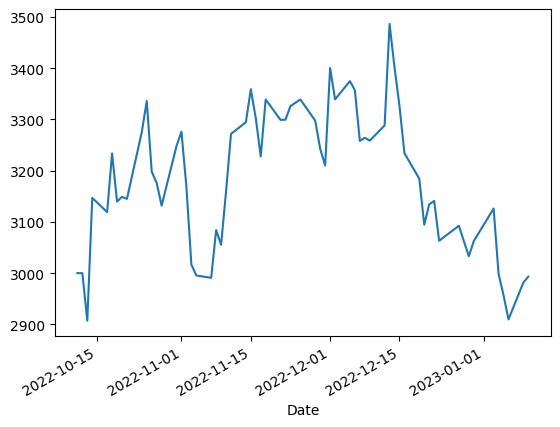

In [8]:
tickets =  ['AAPL', 'T','MSFT']
port = Portfolio(tickets, stocks,10000);
markowtiz_params = {
    'tickers': ['AAPL', 'T','MSFT'],
    'weight':1
}
strats = [
    *port.markowitz(params = markowtiz_params,weight=1),
    *port.buyEven(3),
  
]
port.addStrat(tickets,strats)
port.backtest_portfolio()

port.positions['total'].plot()
# port.stocks['AAPL'].positions.total.plot()
# port.markowitz(params = markowtiz_params,weight=1)['T'].positions
# stocks

# tickers

Optimum {'AAPL': 0.027466758756858955, 'T': 0.8030683309623509, 'MSFT': 0.16946491028079017}
adding multiple strats
{'T': <__main__.Stock object at 0x000001740DCA60D0>, 'MSFT': <__main__.Stock object at 0x000001740DCA6280>}
adding multiple strats
{'T': <__main__.Stock object at 0x000001740DCA60D0>, 'MSFT': <__main__.Stock object at 0x000001740DCA6280>}
adding single strat


<AxesSubplot:xlabel='Date'>

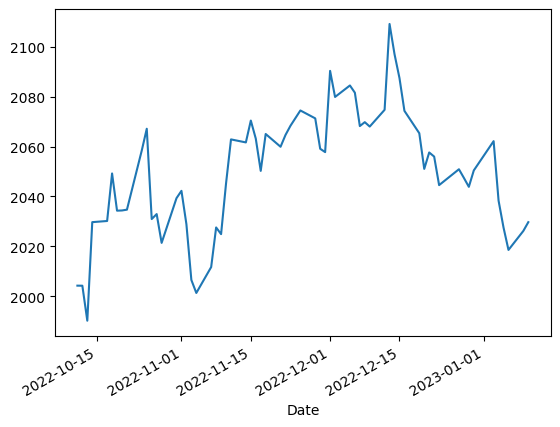

In [9]:
tickers =[ 'T','MSFT']
port = Portfolio(tickers, stocks,10000);
params = {
    'tickers': tickers,
    'weight':1
}
strats = [
    *port.markowitz(params = markowtiz_params,weight=1),
    *port.buyEven(1),
  
]

port.addStrat(['T','MSFT'],strats)


# print(len(stock.macd(long = 21, short = 1)))
# print(isinstance(strats, pd.DataFrame))

port.addStrat(['T'],'macd',long=21,short=1)

# port.addStrat(['T'],stock.macd(long = 21, short = 1))
# port.addStrat(['T'],strat='macd',long = 21, short = 1)
# port.stocks['T'].strategies.append(stock.macd(long = 21, short = 1))
# port.stocks['T'].strategies[2]
# port.strategies = strats

port.backtest_portfolio()
port.positions.total.plot()

# port.stocks['T'].strategies[1]['T'].strategies[1]
# port.markowitz(params = markowtiz_params,weight=1)



# port.buyEven(1)
# port.stocks
# stock.macd(long = 21, short = 1)